In [25]:
import SOAPify.HDF5er as HDF5er
from SOAPify import (
    saponifyTrajectory,
    fillSOAPVectorFromdscribe,
    normalizeArray,
    getSOAPSettings,
)
from SOAPify.analysis import timeSOAPsimple
import h5py
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np
from multiprocessing.pool import ThreadPool as Pool
from seaborn import kdeplot
import dscribe

SOAPrcut = 50 # Ångström (Distance for Ca2+ - COO- bond as optimised by cutoff_verification. also 2x0.25 which is a classical AA cutoff)
SOAPnmax = 8
SOAPlmax = 8


In [2]:
%%bash
module load plumed/2.7.1
module load gromacs/2021
name=run30_again_ions
printf "10\n" | gmx editconf -f ../run/run/${name}.part0002.gro -n ../run/run/run30_motorions.ndx -o ../run/run/${name}.pdb
sed -i 's/\bA1\b/O1/g; s/\bA2\b/O2/g; s/\bCA\b/Ca/g' ../run/run/${name}.pdb

                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 167463 atoms
Volume: 12923.2 nm^3, corresponds to roughly 5815400 electrons
Velocities found
Selected 10: 'Ions_MOTOR'


In [ ]:
%%bash
module load plumed/2.7.1
module load gromacs/2021
mkdir -p ../SOAP
name=run30_again_ions
gmx make_ndx -f ../run/run/${name}.pdb -o ../SOAP/core.ndx << EOF
a CA O1 O2
name 7 O_Ions
q

EOF
gmx check -f ../run/run/${name}.xtc 
echo 7 | gmx trjconv -f ../run/run/${name}.xtc  -s ../run/run/${name}.pdb -o ../SOAP/cores.gro -n ../SOAP/core.ndx -dump 10000000
echo 7 | gmx trjconv -f ../run/run/${name}.xtc  -s ../run/run/${name}.pdb -o ../SOAP/cores.xtc -n ../SOAP/core.ndx -e 10010000
sed -i 's/\bA1\b/O1/g; s/\bA2\b/O2/g; s/\bCA\b/Ca/g' ../SOAP/cores.gro
rm ../SOAP/\#*
rm ../SOAP/CG-fibr*.hdf5
SOAPify-prepareTrajectory ../SOAP/cores.gro ../SOAP/fibre.hdf5 -t ../SOAP/cores.xtc -u atom_style "all"

                 :-) GROMACS - gmx make_ndx, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

Going to read 0 old index file(s)
Analysing residue names:
There are: 29700      Other residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

  0 System              : 95700 atoms
  1 Other               : 95700 atoms
  2 MM2                 : 46200 atoms
  3 LLG                 : 16500 atoms
  4 RLG                 : 16500 atoms
  5 HED                 : 13200 atoms
  6 Ions                :  3300 atoms

 nr : group      '!': not  'name' nr name   'splitch' nr    Enter: list groups
 'a': atom       '&': and  'del' nr         'splitres' nr   'l': list residues
 't': atom type  '|': or   'keep' nr        'splitat' nr    'h': help
 'r': residue              'res' nr         'chain' char
 "name": group             'case': case sensitive           'q': save and quit
 'ri': residue index

> 
Found 9900 atoms with names CA O1 O2

  7 CA_O1_O2            :  9900 atoms

> 

> 


                   :-) GROMACS - gmx check, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teemu

Checking file ../run/run/run30_again_ions.xtc


                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 7: 'O_Ions'


                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 7: 'O_Ions'


rm: cannot remove '../SOAP/CG-fibr*.hdf5': No such file or directory08500.000      


Error while terminating subprocess (pid=435123): 


from topology "../SOAP/cores.gro" and trajectory "['../SOAP/cores.xtc']": and creating a new trajectory in
"../SOAP/fibre.hdf5/Trajectories/cores"


/users_home/makke/.local/lib/python3.9/site-packages/MDAnalysis/coordinates/XDR.py:241: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


[0:1000] 1000 1000 chunk of 8856 B


In [ ]:
RAWFILE, SOAPFILE = '../SOAP/fibre.hdf5', '../SOAP/fibresoap.hdf5'
def prepareSOAP(trajFileName, trajAddress, mask=None):
    soapFileName = SOAPFILE
    print(trajFileName, soapFileName)
    with h5py.File(trajFileName, "r") as workFile, h5py.File(
        soapFileName, "a"
    ) as soapFile:
        soapFile.require_group("SOAP")
        # skips if the soap trajectory is already present
        if trajAddress not in soapFile["SOAP"]:
            saponifyTrajectory(
                trajContainer=workFile[f"Trajectories/{trajAddress}"],
                SOAPoutContainer=soapFile["SOAP"],
                SOAPOutputChunkDim=100,
                SOAPnJobs=16,
                SOAPrcut=SOAPrcut,
                SOAPnmax=SOAPnmax,
                SOAPlmax=SOAPlmax,
                SOAPatomMask=mask,
            )
    return soapFileName

soapFileName = prepareSOAP(RAWFILE, 'cores', mask='Ca')

../SOAP/fibre.hdf5 ../SOAP/fibresoap.hdf5


In [24]:
def getTimeSOAP(soapFileName, trajAddress):
    with h5py.File(soapFileName, "r") as f:
        ds = f[f"/SOAP/{trajAddress}"]
        fillSettings = getSOAPSettings(ds)
        print(fillSettings)
        print(ds.shape)
        nAt = ds.shape[1]

        timedSOAP = np.zeros((ds.shape[0] - 1, ds.shape[1]))

        print(timedSOAP.shape)
        slide = 0
        # this looks a lot convoluted, but it is way faster than working one atom
        # at a time
        for c in ds.iter_chunks():
            theSlice = slice(c[0].start - slide, c[0].stop, c[0].step)
            outSlice = slice(c[0].start - slide, c[0].stop - 1, c[0].step)
            print(c[0], theSlice, outSlice)
            timedSOAP[outSlice], _ = timeSOAPsimple(
                normalizeArray(fillSOAPVectorFromdscribe(ds[theSlice], **fillSettings))
            )
            slide = 1

        return nAt, timedSOAP, np.diff(timedSOAP.T, axis=-1)


nAtoms, tSOAP, dtSOAP = getTimeSOAP('../SOAP/fibresoap.hdf5', 'cores')

{'nMax': 8, 'lMax': 8, 'atomTypes': array(['C', 'O'], dtype=object), 'atomicSlices': {'CC': slice(0, 324, None), 'CO': slice(324, 900, None), 'OC': slice(324, 900, None), 'OO': slice(900, 1224, None)}}
(501, 3300, 1224)
(500, 3300)
slice(0, 100, 1) slice(0, 100, 1) slice(0, 99, 1)
slice(100, 200, 1) slice(99, 200, 1) slice(99, 199, 1)
slice(200, 300, 1) slice(199, 300, 1) slice(199, 299, 1)
slice(300, 400, 1) slice(299, 400, 1) slice(299, 399, 1)
slice(400, 500, 1) slice(399, 500, 1) slice(399, 499, 1)
slice(500, 501, 1) slice(499, 501, 1) slice(499, 500, 1)


In [6]:
with h5py.File('../SOAP/fibresoap.hdf5', "r") as f:
        ds = f["/SOAP/cores"]
        fillSettings = getSOAPSettings(ds)
        nAt = ds.shape[1]
        # this looks a lot convoluted, but it is way faster than working one atom
        # at a time
        slide=0
        arr = []
        for c in ds.iter_chunks():
            theSlice = slice(c[0].start - slide, c[0].stop, c[0].step)
            outSlice = slice(c[0].start - slide, c[0].stop - 1, c[0].step)
            print(c[0], theSlice, outSlice)
            arr.append(normalizeArray(fillSOAPVectorFromdscribe(ds[theSlice], **fillSettings)))
            slide = 1

slice(0, 100, 1) slice(0, 100, 1) slice(0, 99, 1)
slice(100, 200, 1) slice(99, 200, 1) slice(99, 199, 1)
slice(200, 300, 1) slice(199, 300, 1) slice(199, 299, 1)
slice(300, 400, 1) slice(299, 400, 1) slice(299, 399, 1)
slice(400, 500, 1) slice(399, 500, 1) slice(399, 499, 1)
slice(500, 501, 1) slice(499, 501, 1) slice(499, 500, 1)


In [7]:
print(tSOAP.shape)
print(arr[0].shape)

(500, 3300)
(100, 3300, 1728)


In [8]:
array = np.concatenate(np.concatenate([arr[i] for i in range(len(arr))], axis=0), axis=0)
print(array.shape)
pca = PCA(n_components=4).fit(array)
print(pca.explained_variance_ratio_)

(1669800, 1728)
[0.89728507 0.03460767 0.03001848 0.0222955 ]


In [9]:
print(sum(pca.explained_variance_ratio_))

0.9842067213073779


/tmp/ipykernel_422433/3868740430.py:2: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.
This will become an error in seaborn v0.13.0; please update your code.

  kdeplot(x=array_pca[::100,0], y=array_pca[::100,1], shade=False, cmap="viridis", shade_lowest=True)
/tmp/ipykernel_422433/3868740430.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(x=array_pca[::100,0], y=array_pca[::100,1], shade=False, cmap="viridis", shade_lowest=True)
/users_home/makke/miniconda3/envs/SOAPify/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users_home/makke/miniconda3/envs/SOAPify/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_i

<Axes: >

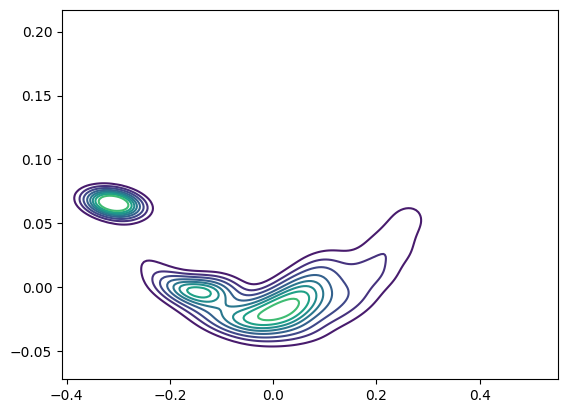

In [10]:
array_pca = pca.transform(array)
kdeplot(x=array_pca[::100,0], y=array_pca[::100,1], shade=False, cmap="viridis", shade_lowest=True)

In [11]:
print(tSOAP.shape)
print(dtSOAP.shape)

(500, 3300)
(3300, 499)


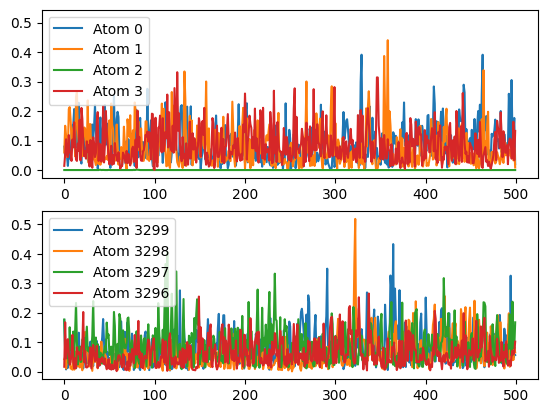

In [12]:
fig, axes = plt.subplots(2, sharey=True)
for i in range(4):
    axes[0].plot(tSOAP[:, i], label=f"Atom {i}")
    axes[1].plot(tSOAP[:, nAtoms - 1 - i], label=f"Atom {nAtoms-1-i}")

for ax in axes:
    ax.legend()

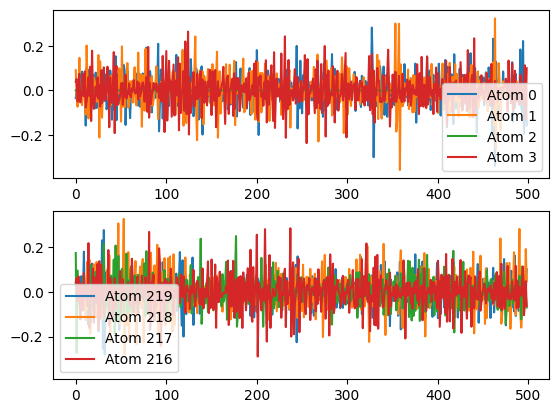

In [13]:
fig, axes = plt.subplots(2, sharey=True)
for i in range(4):
    axes[0].plot(dtSOAP[i], label=f"Atom {i}")
    axes[1].plot(dtSOAP[219 - i], label=f"Atom {219-i}")

for ax in axes:
    ax.legend()

In [14]:
def signaltonoise(a: np.array, axis, ddof):
    """Given an array, retunrs its signal to noise value of its compontens"""
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return 20 * np.log10(abs(np.where(sd == 0, 0, m / sd)))

/tmp/ipykernel_422433/1699030754.py:5: RuntimeWarning: invalid value encountered in divide
  return 20 * np.log10(abs(np.where(sd == 0, 0, m / sd)))
/tmp/ipykernel_422433/1699030754.py:5: RuntimeWarning: divide by zero encountered in log10
  return 20 * np.log10(abs(np.where(sd == 0, 0, m / sd)))


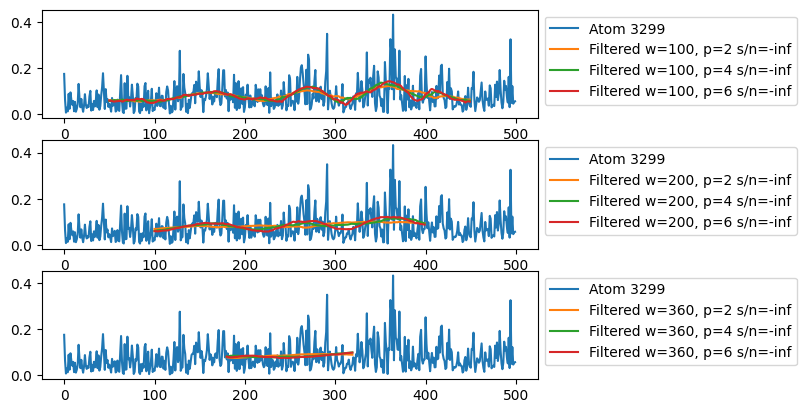

In [15]:
atom = nAtoms - 1
savGolPrint = np.arange(tSOAP.T[atom].shape[0])
windows = [100, 200, 360]
polyorders = [2, 4, 6]
fig, axes = plt.subplots(len(windows), sharey=True)

for ax, window_length in zip(axes, windows):
    windowToPlot = slice(window_length // 2, -window_length // 2)
    ax.plot(tSOAP.T[atom], label=f"Atom {atom}")
    for polyorder in polyorders:
        savgol = savgol_filter(
            tSOAP.T, window_length=window_length, polyorder=polyorder, axis=-1
        )

        sr_ratio = signaltonoise(savgol[:, windowToPlot], axis=-1, ddof=0)

        ax.plot(
            savGolPrint[windowToPlot],
            savgol[atom, windowToPlot],
            label=f"Filtered w={window_length}, p={polyorder} s/n={np.mean(sr_ratio):.2f}",
        )
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

/tmp/ipykernel_422433/1699030754.py:5: RuntimeWarning: invalid value encountered in divide
  return 20 * np.log10(abs(np.where(sd == 0, 0, m / sd)))
/tmp/ipykernel_422433/1699030754.py:5: RuntimeWarning: divide by zero encountered in log10
  return 20 * np.log10(abs(np.where(sd == 0, 0, m / sd)))


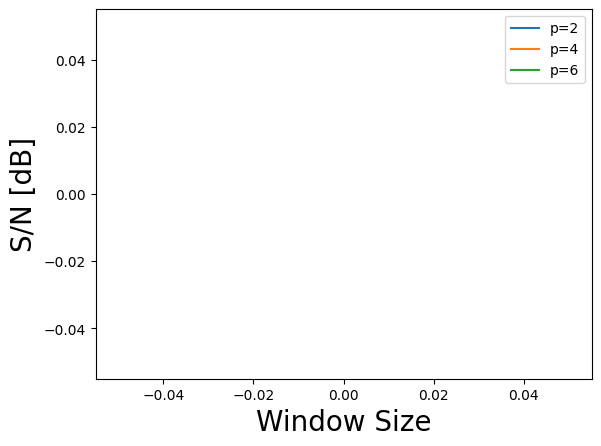

In [16]:
windows = np.arange(10, 300, 20)
polyorders = [2, 4, 6]
fig, ax = plt.subplots(1)


for polyorder in polyorders:
    meansrRatios = np.empty((len(windows), 2))
    for i, window_length in enumerate(windows):
        windowToPlot = slice(window_length // 2, -window_length // 2)
        savgol = savgol_filter(
            tSOAP.T, window_length=window_length, polyorder=polyorder, axis=-1
        )
        sr_ratio = signaltonoise(savgol[:, windowToPlot], axis=-1, ddof=0)
        meansrRatios[i] = [window_length, np.mean(sr_ratio)]
    ax.plot(meansrRatios[:, 0], meansrRatios[:, 1], label=f"p={polyorder}")
ax.set_xlabel("Window Size", fontsize=20)
ax.set_ylabel("S/N [dB]", fontsize=20)

_ = ax.legend()

In [17]:
window_length = 30
polyorder = 2
windowToUSE = slice(window_length // 2, -window_length // 2)
filteredtSOAP = savgol_filter(
    tSOAP.T, window_length=window_length, polyorder=polyorder, axis=-1
)

In [18]:
bestnclusters = 4
clusters = KMeans(bestnclusters, random_state=12345).fit_predict(
    filteredtSOAP.reshape(-1, 1)
)
data_KM = {}
for i in range(bestnclusters):
    data_KM[i] = {}
    data_KM[i]["elements"] = filteredtSOAP.reshape((-1))[clusters == i]
    data_KM[i]["min"] = np.min(data_KM[i]["elements"])
    data_KM[i]["max"] = np.max(data_KM[i]["elements"])

/users_home/makke/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [19]:
minmax = [[cname, data["max"]] for cname, data in data_KM.items()]
minmax = sorted(minmax, key=lambda x: x[1])
cmap = ListedColormap([f"C{m[0]}" for m in minmax])
norm = BoundaryNorm([0] + [m[1] for m in minmax], cmap.N)

In [20]:
def prepareData(x, /):
    """prepares an array from shape (atom,frames) to  (frames,atom)"""
    shape = x.shape
    toret = np.empty((shape[1], shape[0]), dtype=x.dtype)
    for i, atomvalues in enumerate(x):
        toret[:, i] = atomvalues
    return toret


# classyfing by knoing the min/max of the clusters
def classifying(x, classDict):
    toret = np.ones_like(x, dtype=int) * (len(classDict) - 1)
    # todo: sort  by max and then classify
    minmax = [[cname, data["max"]] for cname, data in data_KM.items()]
    minmax = sorted(minmax, key=lambda x: -x[1])
    # print(minmax)
    for cname, myMax in minmax:
        toret[x < myMax] = int(cname)
    return toret


classifiedFilteredtSOAP = classifying(filteredtSOAP, data_KM)


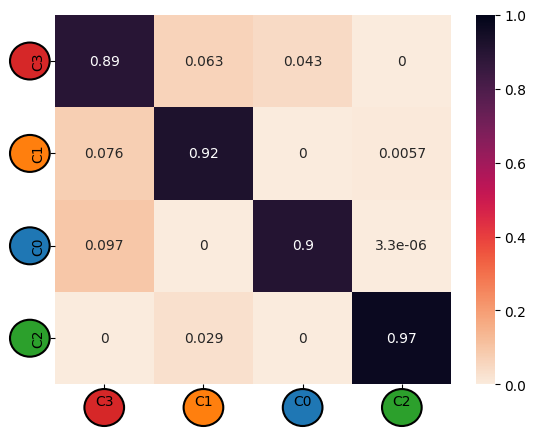

In [21]:
from SOAPify import SOAPclassification, calculateTransitionMatrix, normalizeMatrixByRow
from seaborn import heatmap

classifications = SOAPclassification(
    [], prepareData(classifiedFilteredtSOAP), [f"C{m[0]}" for m in minmax]
)
tmat = calculateTransitionMatrix(classifications)
tmat = normalizeMatrixByRow(tmat)
_, ax = plt.subplots(1)
heatmap(
    tmat,
    vmax=1,
    vmin=0,
    cmap="rocket_r",
    annot=True,
    xticklabels=classifications.legend,
    yticklabels=classifications.legend,
    ax=ax,
)

for i, label in enumerate(classifications.legend):
    ax.add_patch(
        Circle(
            (0.5 + i, len(classifications.legend) + 0.25),
            facecolor=label,
            lw=1.5,
            edgecolor="black",
            radius=0.2,
            clip_on=False,
        )
    )
    ax.add_patch(
        Circle(
            (-0.25, 0.5 + i),
            facecolor=label,
            lw=1.5,
            edgecolor="black",
            radius=0.2,
            clip_on=False,
        )
    )